In [ ]:
import cv2
import numpy as np
import os
import imutils
from tensorflow.keras.models import load_model
from IPython.display import display, Image, clear_output

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
try:
    net = cv2.dnn.readNet("/content/drive/MyDrive/Helmet_motorcycle/yolov3-custom_7000.weights", "/content/drive/MyDrive/Helmet_motorcycle/yolov3-custom.cfg")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
except cv2.error as e:
    print(f"Error loading YOLOv3 model: {e}")
    exit()

In [ ]:
# Load CNN model
try:
    model = load_model('/content/drive/MyDrive/Helmet_motorcycle/helmet-nonhelmet_cnn.h5')
    print('Model loaded!!!')
except Exception as e:
    print(f"Error loading CNN model: {e}")
    exit()

Model loaded!!!


In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Helmet_motorcycle/video.mp4')

In [ ]:
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

In [ ]:
COLORS = [(0, 255, 0), (0, 0, 255)]

In [ ]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*"XVID")
writer = cv2.VideoWriter('output3.avi', fourcc, 5, (888, 500))

In [ ]:
def helmet_or_nohelmet(helmet_roi):
    try:
        helmet_roi = cv2.resize(helmet_roi, (224, 224))
        helmet_roi = np.array(helmet_roi, dtype='float32') / 255.0
        helmet_roi = helmet_roi.reshape(1, 224, 224, 3)
        return int(model.predict(helmet_roi)[0][0])
    except Exception as e:
        print(f"Error during helmet classification: {e}")
        return -1

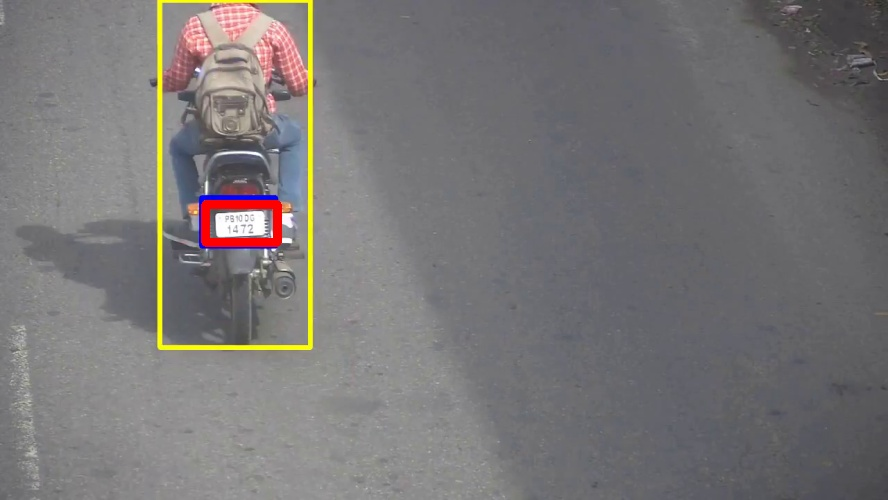

In [ ]:
ret = True
frame_count = 0

while ret:
    ret, img = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 2 == 0:  # Process every other frame (adjust as needed)
        continue

    img = imutils.resize(img, height=500)
    height, width = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    confidences = []
    boxes = []
    classIds = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                classIds.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            color = [int(c) for c in COLORS[classIds[i]]]
            if classIds[i] == 0:  # Bike
                helmet_roi = img[max(0, y):min(y + h, height), max(0, x):min(x + w, width)]
            else:  # Number plate
                x_h = max(0, x - 60)
                y_h = max(0, y - 350)
                w_h = w + 100
                h_h = h + 100
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 7)
                if y_h > 0 and x_h > 0:
                    h_r = img[y_h:y_h + h_h, x_h:x_h + w_h]
                    c = helmet_or_nohelmet(h_r)
                    if c != -1:
                        cv2.putText(img, ['helmet', 'no-helmet'][c], (x, y - 100),
                                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                        cv2.rectangle(img, (x_h, y_h), (x_h + w_h, y_h + h_h), (255, 0, 0), 10)

    writer.write(img)

    # Display processed frame in notebook
    _, frame_encoded = cv2.imencode('.JPEG', img)
    display(Image(data=frame_encoded.tobytes()))

    clear_output(wait=True)

In [ ]:
cap.release()
writer.release()
cv2.destroyAllWindows()